### HowTo: modeling tidal boundaries with `TTim`

This notebook shows how tidal boundary conditions can be modeled with TTim.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim

Define some parameters for a single aquifer. There is a tidal boundary condition at $x=0$ and a semi-infinite aquifer to the right. 

In [2]:
# parameters
k = 20.0  # hydraulic conductivity, m/d
H = 50.0  # thickness of aquifer, m
T = k * H  # transmissivity, m^2/d
S = 0.1  # storage coefficient, -
tau = 0.5  # tidal period, d
tp = 0.125  # time of peak at canal, d

The analytic solution for the head is given by the following function.

In [3]:
# solution for unit amplitude
def analytic_head(x, t, tau, S, T, tp=0):
    B = np.exp(-x * np.sqrt(S * np.pi / (T * tau)))
    ts = x * np.sqrt(S * tau / (4 * np.pi * T))
    return B * np.cos(2 * np.pi * (t - tp - ts) / tau)

The input time series for the TTim model is extended for several days to get the model to spin-up. In interpreting the results, we only look at the heads in the final tidal period.

In [4]:
ndays = 5
t = np.linspace(0, ndays * 2 * tau, ndays * 50)
hstar = np.sin(2 * np.pi * t / tau)

There are different ways the tidal boundary can be set in the TTim model based on some synthetic "observed" water level time series:

- No shift, the data is entered as is
- Shift -1, the data shifted backwards in time by one step
- Midpoint, the average between the previous two.

The different choices and how that translates into a boundary condition in TTim is shown below. The "no shift" data is continuously leading the observed water levels, whereas "shift -1" is trailing the observed water levels. The "midpoint" option is the average between the two, and based on this result is expected to best match the analytical solution. 

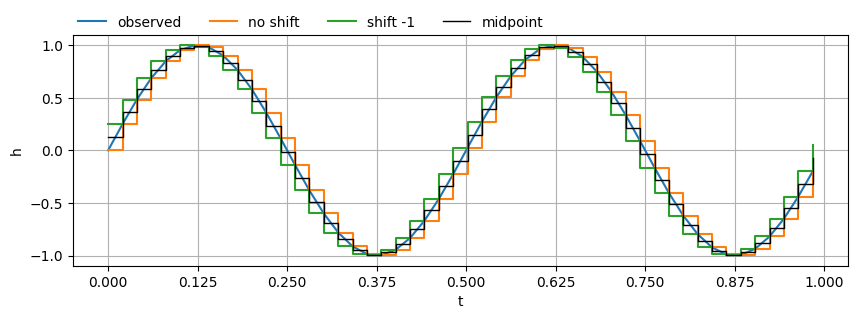

In [5]:
# no shift
hstar = pd.Series(index=t, data=hstar)
# shift 1
hshift = hstar.shift(-1)
# midpoint
hmid = 0.5 * (hstar + hshift.values)

# plot
plt.figure(figsize=(10, 3))
plt.plot(hstar.loc[:1].index, hstar.loc[:1], label="observed")
plt.step(hstar.loc[:1].index, hstar.loc[:1], where="post", label="no shift")
plt.step(hshift.loc[:1].index, hshift.loc[:1], where="post", label="shift -1")
plt.step(
    hmid.loc[:1].index, hmid.loc[:1], where="post", label="midpoint", color="k", lw=1.0
)
plt.ylabel("h")
plt.xlabel("t")
plt.legend(loc=(0, 1), frameon=False, ncol=4)
plt.xticks(np.arange(0, 1.01, 0.125))
plt.grid()

Let's test the three options and compare the results to the analytical solution.

In [6]:
tstart = (ndays - 0.5) * 2 * tau  # use last half-day
t = np.arange(0, tau, tau / 4) + tstart
x = np.linspace(0, 200, 100)

# for storing results
results_at_x = {}
results_along_x = {}

# loop through hstar options
hstar_dict = {"no shift": hstar, "shift -1": hshift, "midpoint": hmid}

for name, ihstar in hstar_dict.items():
    tsandhstar = ihstar.dropna().to_frame().to_records().tolist()

    ml = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)
    tidal = ttim.XsectionMaq(
        ml,
        -np.inf,
        0.0,
        kaq=k,
        z=[1.0, 0, -H],
        Saq=1e-10,
        c=1e-10,
        topboundary="semi",
        tsandhstar=tsandhstar,
    )
    land = ttim.XsectionMaq(
        ml,
        0.0,
        np.inf,
        kaq=k,
        z=[1.0, 0, -H],
        Saq=S / H,
        c=1e10,
        topboundary="semi",
    )
    ml.solve(silent=True)

    h_at_x = ml.head(50.0, 0.0, hstar.index.to_numpy())
    results_at_x[name] = h_at_x

    h_t = ml.headalongline(x, np.zeros_like(x), t)
    results_along_x[name] = h_t

Compare the results. First we look at the head along $x$ at 4 moments in the tidal period. As we can see the "midpoint" option best matches the analytical solution. It still isn't quite equal to the analytical solution near $x=0$ because of the discretization of the input time series. If we had used more points to approximate our tidal signal, the results would be closer together. 

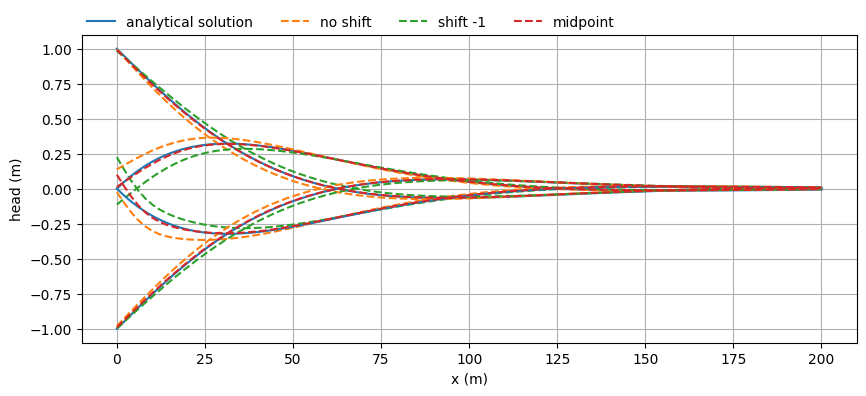

In [7]:
# basic plot
plt.figure(figsize=(10, 4))
x = np.linspace(0, 200, 100)
for i, ti in enumerate(np.arange(tau / 4, tau + 1e-5, tau / 4)):
    h = analytic_head(x, ti, tau, S, T, tp=tp)
    (p0,) = plt.plot(x, h, color="C0", label="analytical solution")
    (p1,) = plt.plot(
        x,
        results_along_x["no shift"][0, i],
        color="C1",
        ls="dashed",
        label="no shift",
    )
    (p2,) = plt.plot(
        x,
        results_along_x["shift -1"][0, i],
        color="C2",
        ls="dashed",
        label="shift -1",
    )
    (p3,) = plt.plot(
        x,
        results_along_x["midpoint"][0, i],
        color="C3",
        ls="dashed",
        label="midpoint",
        zorder=10,
    )
# for the amplitude envelope
# mu = np.sqrt(T * tau / (S * np.pi))  # characteristic length, m
# plt.plot(x, np.exp(-x / mu), "k--")
# plt.plot(x, -np.exp(-x / mu), "k--")
plt.xlabel("x (m)")
plt.ylabel("head (m)")
handles = [p0, p1, p2, p3]
labels = [h.get_label() for h in handles]
plt.legend(handles, labels, loc=(0, 1), frameon=False, ncol=4)
plt.grid()

Next we compare the head at $x=50$ m for the last tidal period. Here we can clearly see the "no shift" and "shift -1" leading and trailing the analytical solution. The "midpoint" option matches nicely with the analytical solution. 

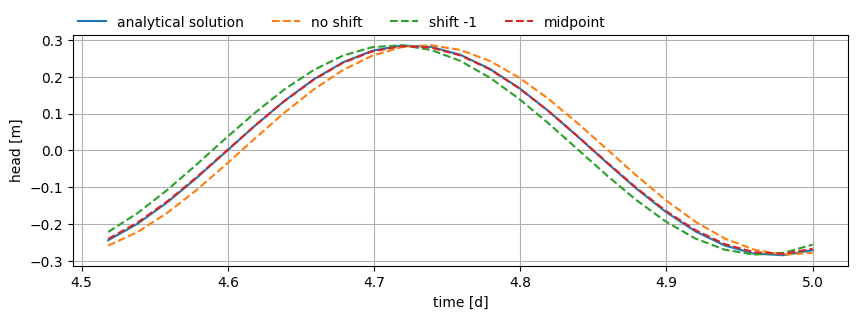

In [8]:
t = hstar.index.to_numpy()[-25:]
ha = analytic_head(50.0, t, tau, S, T, tp=tp)
plt.figure(figsize=(10, 3))
plt.plot(t, ha, label="analytical solution")
plt.plot(t, results_at_x["no shift"].squeeze()[-25:], label="no shift", ls="dashed")
plt.plot(t, results_at_x["shift -1"].squeeze()[-25:], label="shift -1", ls="dashed")
plt.plot(t, results_at_x["midpoint"].squeeze()[-25:], label="midpoint", ls="dashed")
plt.legend(loc=(0, 1), frameon=False, ncol=4)
plt.xlabel("time [d]")
plt.ylabel("head [m]")
plt.grid()

In conclusion, when modeling tidal boundary conditions in TTim, use the "midpoint" approximation as the input time series for your model.